### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
import numpy as np
import copy

def binarize(X):
    bin_X = copy.deepcopy(X)
    # Take the mean as threshold
    bin_X[bin_X < np.mean(np.mean(X, 1))] = 0
    bin_X[bin_X > np.mean(np.mean(X, 1))] = 1
    return bin_X.astype(float)

In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

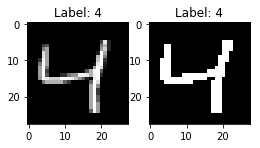

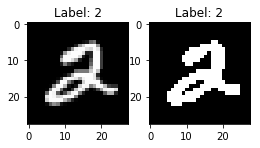

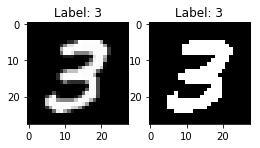

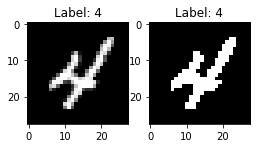

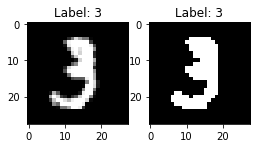

In [44]:
import matplotlib.pyplot as plt

# visualization
def visualize(digit=[], num_examples=5, color_space='gray'):
    if len(digit) > 0:
        plt.figure(figsize=(3,3))
        num1 = np.reshape(digit, [28, 28])
        plt.imshow(num1, cmap='gray', interpolation='nearest')
        plt.title('Digit')
        plt.show()
    else:
        examples = 0
        index = 0
        while examples < num_examples:
            if train_labels[index] in [2, 3, 4]:
                plt.figure(figsize=(4,2))
                title_str = 'Label: '+str(train_labels[index])
                
                # sp1
                plt.subplot(121)
                num1 = np.reshape(train_data[index], [28, 28])
                plt.imshow(num1, cmap='gray', interpolation='nearest')
                plt.title(title_str)

                # sp2
                plt.subplot(122)
                num2 = np.reshape(bin_train_data[index], [28, 28])
                plt.imshow(num2, cmap='gray', interpolation='nearest')
                plt.title(title_str)

                plt.show()

                examples += 1

            index += 1
        
visualize()

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
def bernoulli(x, mu):
    return np.power((mu+1e-10), x) * np.power((1-(mu+1e-10)),(1-x))

In [6]:
def E_step(X, mu, pi): # BISHOP 9.23
    datapoints = np.shape(X)[0] # N
    latent_vars = np.shape(pi)[0] # K
    gamma = np.zeros([datapoints, latent_vars])
    
    # loop through all datapoints
    for n in range(datapoints):
                
        # calculate the normalization term (denominator) and numerators
        normalization = 0
        numerators = np.zeros([latent_vars])
        for j in range(latent_vars):
            numerator = pi[j] * np.prod(bernoulli(X[n], mu[j]))
            normalization += numerator
            numerators[j] = numerator
            
        # calculate for each latent variable: numerator divided by normalization
        gamma[n, :] = numerators / np.sum(numerators)

    return gamma

In [7]:
#nb stripout filename

In [8]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [9]:
def M_step(X, gamma):
    mu = ((X.T @ gamma) / np.sum(gamma, 0)).T
    pi = np.sum(gamma, 0) / np.shape(X)[0]
    return mu, pi

In [10]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [11]:
def EM(X, K, max_iter, mu=[], pi=[]):
 
    # Init
    if len(mu) == 0:
        mu = np.random.uniform(low=.25, high=.75, size=(K, np.shape(X)[1]))
    if len(pi) == 0:
        pi = np.ones(K) / float(K)
    
    prev_mu = mu
    prev_pi = pi
    prev_log_likelihood = 0
    
    for i in range(max_iter):
        print("ITERATION", i+1)
        gamma = E_step(X, mu, pi) # E-STEP
        mu, pi = M_step(X, gamma) # M-STEP

        # TODO: COMPUTE LOG LIKELIHOOD
        
        # loop through all datapoints
        log_likelihood = 0
        for n in range(np.shape(X)[0]):
            division_sum = 0
            for j in range(K):
                division_sum += pi[j] * np.prod(bernoulli(X[n], mu[j]))
            log_likelihood += np.log(division_sum)
        print('log likelikhood', log_likelihood)
        
        if (np.allclose(mu, prev_mu) or 
            np.allclose(pi, prev_pi) or 
            np.allclose(log_likelihood, prev_log_likelihood)):
            return gamma, mu, pi, i
            
    return gamma, mu, pi, i

gamma, mu, pi, i = EM(bin_train_data[:5000], 10, 2) 

ITERATION 1
log likelikhood -1041735.3781040714
ITERATION 2
log likelikhood -956415.0544762701


### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [12]:
train2 = bin_train_data[train_labels == 2] # Digits 2
train3 = bin_train_data[train_labels == 3] # Digits 3
train4 = bin_train_data[train_labels == 4] # Digits 4

select_bin_train_data = np.concatenate((train2, train3, train4))
select_bin_train_labels = np.concatenate((
    np.ones([np.shape(train2)[0]])*2, 
    np.ones([np.shape(train3)[0]])*3, 
    np.ones([np.shape(train4)[0]])*4))

gamma, mu, pi, i = EM(select_bin_train_data, 3, 20)

ITERATION 1
log likelikhood -3891576.8430404933
ITERATION 2
log likelikhood -3674390.141311125
ITERATION 3
log likelikhood -3638664.003268387
ITERATION 4
log likelikhood -3624494.2508085957
ITERATION 5
log likelikhood -3619430.298015175
ITERATION 6
log likelikhood -3617478.2255597454
ITERATION 7
log likelikhood -3616601.4526690245
ITERATION 8
log likelikhood -3616259.23582873
ITERATION 9
log likelikhood -3616093.3705046745
ITERATION 10
log likelikhood -3616045.648796389
ITERATION 11
log likelikhood -3616020.3224920873
ITERATION 12
log likelikhood -3616009.044335406
ITERATION 13
log likelikhood -3616006.2151247533
ITERATION 14
log likelikhood -3616005.3494619634
ITERATION 15
log likelikhood -3616003.470761941
ITERATION 16
log likelikhood -3615992.2031126395
ITERATION 17
log likelikhood -3615992.0722301416
ITERATION 18
log likelikhood -3615992.0527870883
ITERATION 19
log likelikhood -3615992.046167618
ITERATION 20
log likelikhood -3615992.0437776214


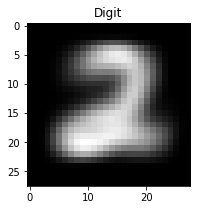

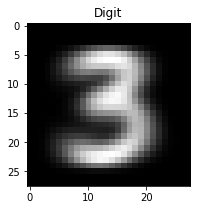

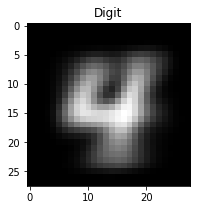

In [45]:
for mu_ in mu:
    visualize(mu_)

In [14]:
def assign_cluster(X, K, pi, mu, labels):
    cluster_count = np.zeros([K, int(np.max(labels))+1])
    for n in range(len(X)):
        division_sum = np.zeros([K])
        for j in range(K):
            division_sum[j] = pi[j] * np.prod(bernoulli(X[n], mu[j]))
        log_likelihood = np.log(division_sum)
        cluster_count[np.argmax(log_likelihood)][int(labels[n])] += 1
            
    return np.argmax(cluster_count, 1)
    
cluster_assignment = assign_cluster(select_bin_train_data, 3, pi, mu, select_bin_train_labels)
cluster_assignment

/Users/Nils/anaconda3/envs/ml2labs/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


array([4, 3, 2])

In [15]:
lengths = [np.shape(train2)[0], np.shape(train3)[0], np.shape(train4)[0]]
ratio = lengths / np.sum(lengths)

print('Data ratio ', ratio[cluster_assignment-2])
print('Priors     ', pi)

Data ratio  [0.32580447 0.34192181 0.33227372]
Priors      [0.34813294 0.33554871 0.31631834]


Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

Yes, by assigning each digits label to a cluster using the maximum likelihood and choosing the most assigned label as cluster label.

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

In [16]:
gamma_larger, mu_larger, pi_larger, i_larger = EM(select_bin_train_data, 5, 20)

ITERATION 1
log likelikhood -3799989.544206116
ITERATION 2
log likelikhood -3568082.247674687
ITERATION 3
log likelikhood -3521795.993795295
ITERATION 4
log likelikhood -3499724.204147805
ITERATION 5
log likelikhood -3486601.570700848
ITERATION 6
log likelikhood -3479804.995252595
ITERATION 7
log likelikhood -3474852.0187601396
ITERATION 8
log likelikhood -3470675.4170469246
ITERATION 9
log likelikhood -3466469.3055532137
ITERATION 10
log likelikhood -3461395.933472511
ITERATION 11
log likelikhood -3456084.1941094827
ITERATION 12
log likelikhood -3450810.6620879397
ITERATION 13
log likelikhood -3446469.1853909194
ITERATION 14
log likelikhood -3443501.5395185677
ITERATION 15
log likelikhood -3441563.2114943084
ITERATION 16
log likelikhood -3440350.7776106913
ITERATION 17
log likelikhood -3439661.5306816725
ITERATION 18
log likelikhood -3439256.331559862
ITERATION 19
log likelikhood -3439018.9258065415
ITERATION 20
log likelikhood -3438881.4845542535


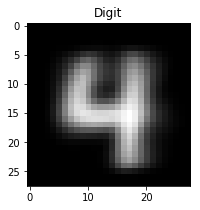

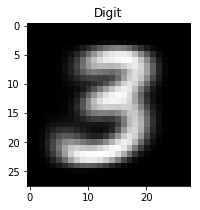

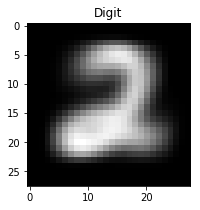

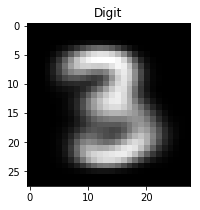

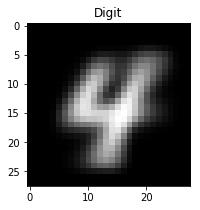

In [46]:
for mu_ in mu_larger:
    visualize(mu_)

When using more clusters than labels, it seems that one digit is divided in multiple clusters, based on multiple handwriting styles for that digit.

In [18]:
gamma_smaller, mu_smaller, pi_smaller, i_smaller = EM(select_bin_train_data, 2, 20)

ITERATION 1
log likelikhood -3976698.425496411
ITERATION 2
log likelikhood -3881357.0511377165
ITERATION 3
log likelikhood -3864051.644331698
ITERATION 4
log likelikhood -3854429.641922595
ITERATION 5
log likelikhood -3844278.797159234
ITERATION 6
log likelikhood -3833735.5132582276
ITERATION 7
log likelikhood -3828381.73304742
ITERATION 8
log likelikhood -3826851.3220221214
ITERATION 9
log likelikhood -3825910.2466894225
ITERATION 10
log likelikhood -3825431.6266911775
ITERATION 11
log likelikhood -3825226.5931032905
ITERATION 12
log likelikhood -3825117.159471593
ITERATION 13
log likelikhood -3825040.889694775
ITERATION 14
log likelikhood -3824992.9287996693
ITERATION 15
log likelikhood -3824958.310151237
ITERATION 16
log likelikhood -3824932.9055961724
ITERATION 17
log likelikhood -3824913.5805569673
ITERATION 18
log likelikhood -3824912.0345877428
ITERATION 19
log likelikhood -3824911.5423305924
ITERATION 20
log likelikhood -3824911.3694646214


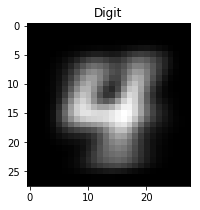

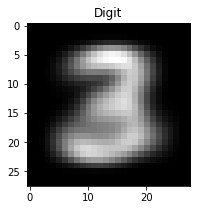

In [47]:
for mu_ in mu_smaller:
    visualize(mu_)

When using less clusters than labels, multiple digits are combined in one cluster. Those are the digits that look most alike, for example 2 and 3 are combined in one cluster as they differ the most from 4.

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

In [22]:
def find_misclassifications(data, mu, pi):
    gamma = E_step(data, mu, pi) # Find responsibilities

    maximum_responsibility_cluster = argmax(gamma, 1)
    maximum_resposibility_label = copy.deepcopy(maximum_responsibility_cluster)
    for i in range(shape(gamma)[1]):
        maximum_resposibility_label[maximum_responsibility_cluster == i] = cluster_assignment[i]

    correct_classification = maximum_resposibility_label == select_bin_train_labels
    misclassified_idx = [i for i, x in enumerate(correct_classification) if not x]
    print(len(misclassified_idx), 'out of', shape(gamma)[0], 'digits are misclassified.')
    return misclassified_idx, maximum_resposibility_label

misclassified_idx, maximum_resposibility_label = find_misclassifications(select_bin_train_data, mu, pi)

1786 out of 17931 digits are misclassified.


In [48]:
for i in range(5):
    print('Predicted label', maximum_resposibility_label[misclassified_idx][i])
    print('Ground truth   ', int(select_bin_train_labels[misclassified_idx][i]))
    visualize(select_bin_train_data[misclassified_idx][i])

IndexError: too many indices for array

Digits are misclassified, probably because they are written very different or in another location from most of the digits that belong to this cluster. They do not match the means of the bernoulli distribution of the ground truth cluster and have a higher similarity with another cluster. 

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

In [24]:
init_pi = ratio
init_mu = np.zeros([np.shape(ratio)[0], np.shape(select_bin_train_data)[1]])

print(np.shape(init_mu))

for i, label in enumerate(set(select_bin_train_labels)):
    init_mu[i] = np.mean(select_bin_train_data[int(label) == select_bin_train_labels], 0)

gamma, mu, pi, i = EM(select_bin_train_data, 3, 20, mu=init_mu, pi=init_pi)

(3, 784)
ITERATION 1
log likelikhood -3618798.2882876266
ITERATION 2
log likelikhood -3617406.476874755
ITERATION 3
log likelikhood -3616655.904376147
ITERATION 4
log likelikhood -3616337.966825481
ITERATION 5
log likelikhood -3616154.0064218934
ITERATION 6
log likelikhood -3616086.805714766
ITERATION 7
log likelikhood -3616057.2291040826
ITERATION 8
log likelikhood -3616049.122472309
ITERATION 9
log likelikhood -3616045.4078151556
ITERATION 10
log likelikhood -3616043.460075387
ITERATION 11
log likelikhood -3616042.5006805286
ITERATION 12
log likelikhood -3616042.03272852
ITERATION 13
log likelikhood -3616041.8438731935
ITERATION 14
log likelikhood -3616041.7733805054
ITERATION 15
log likelikhood -3616041.745467752
ITERATION 16
log likelikhood -3616041.733868856
ITERATION 17
log likelikhood -3616041.728888863
ITERATION 18
log likelikhood -3616041.726692631
ITERATION 19
log likelikhood -3616041.725701073
ITERATION 20
log likelikhood -3616041.725243878


The euclidic distance between the initial mu and the mu after convergence are [0.73796995 0.61043468 0.2483387 ]
12196 out of 17931 digits are misclassified.


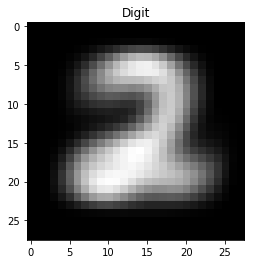

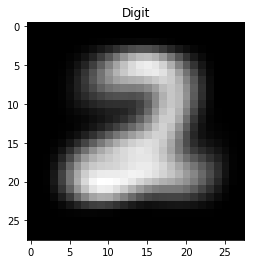

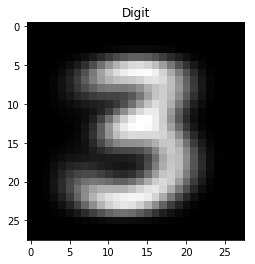

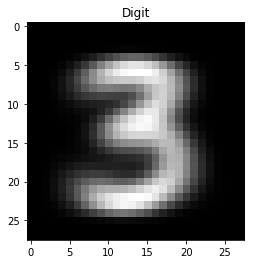

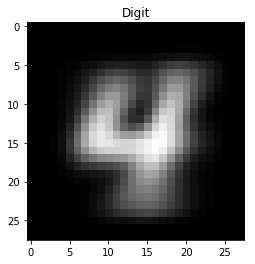

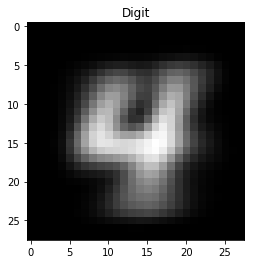

In [25]:
print('The euclidic distance between the initial mu and the mu after convergence are', sqrt(sum((init_mu - mu)**2, 1)))

misclassified_idx = find_misclassifications(select_bin_train_data, mu, pi)

for init_mu_, mu_ in zip(init_mu, mu):
    visualize(init_mu_)
    visualize(mu_)

It seems that the initial cluster means are not very different from the ones after EM convergence. Also, the initial loss is smaller than when initializing with random means and pi's. However, the final performance does not seem to be effected after 20 iterations.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [49]:
def log_bernoulli_loss(x_hat, x):
    return -torch.sum(x*torch.log(x_hat) + (1-x)*torch.log(1-x_hat))

In [50]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE 
# TODO
# TODO
Dit lukte dus voor geen meter

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [51]:
# http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html
def KL_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))

In [52]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [53]:
def loss_function(x_hat, x, mu, logvar):
    return log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)

In [54]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [55]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [113]:
def encode(self, x):
    output_fc1 = F.relu(self.fc1(x))
    mu = F.relu(self.fc21(output_fc1))
    logvar = F.relu(self.fc22(output_fc1))
    return mu, logvar

In [114]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [104]:
def reparameterize(self, mu, logvar):
    m = torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0]))
    epsilon = m.sample((shape(logvar)[0],))
    z = mu + torch.sqrt(torch.exp(logvar)) * epsilon
    return z

In [105]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [106]:
def decode(self, z):
    output_fc3 = F.relu(self.fc3(z))
    x_hat = F.sigmoid(self.fc4(output_fc3))
    return x_hat

In [107]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [108]:
def forward(self, x):
    x = x.view(-1, 784)
    mu, logvar = encode(self, x)
    z = reparameterize(self, mu, logvar)
    x_hat = decode(self, z)
    
    return x_hat, mu, logvar

In [109]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [110]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [111]:
# Hyperparameters
d_size = 784
layer1 = 300
layer2 = 50
layer3 = 300

fc1_dims  = (d_size, layer1)
fc21_dims = (layer1, layer2)
fc22_dims = (layer1, layer2)
fc3_dims  = (layer2, layer3)
fc4_dims  = (layer3, d_size)

#lr = 0.0001
#batch_size = 1000
#epochs = 10
lr = 0.0003
batch_size = 1000
epochs = 15

In [ ]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [115]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 548.557434
====> Epoch: 1 Average loss: 368.7648
Train Epoch: 2 [0/60000 (0%)]	Loss: 250.845123
====> Epoch: 2 Average loss: 231.5101
Train Epoch: 3 [0/60000 (0%)]	Loss: 220.257843
====> Epoch: 3 Average loss: 211.9482
Train Epoch: 4 [0/60000 (0%)]	Loss: 204.282715
====> Epoch: 4 Average loss: 195.6064
Train Epoch: 5 [0/60000 (0%)]	Loss: 187.278732
====> Epoch: 5 Average loss: 181.1428
Train Epoch: 6 [0/60000 (0%)]	Loss: 173.262344
====> Epoch: 6 Average loss: 167.4847
Train Epoch: 7 [0/60000 (0%)]	Loss: 161.211014
====> Epoch: 7 Average loss: 156.4384
Train Epoch: 8 [0/60000 (0%)]	Loss: 151.589844
====> Epoch: 8 Average loss: 148.4845
Train Epoch: 9 [0/60000 (0%)]	Loss: 144.569595
====> Epoch: 9 Average loss: 141.8692
Train Epoch: 10 [0/60000 (0%)]	Loss: 142.179886
====> Epoch: 10 Average loss: 136.0258
Train Epoch: 11 [0/60000 (0%)]	Loss: 132.514526
====> Epoch: 11 Average loss: 130.9765
Train Epoch: 12 [0/60000 (0%)]	Loss: 129.119446
====> Epoch: 

Run the box below to check if the model you trained above is able to correctly reconstruct images.

In [ ]:
# Ik begrijp niet waarom die allemaal dezelfde digits maakt

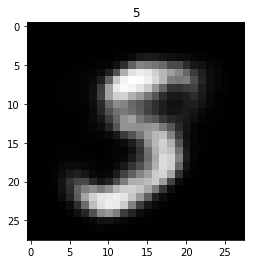

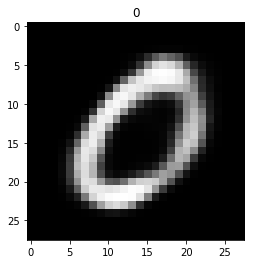

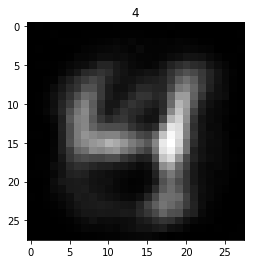

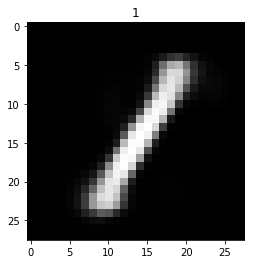

In [116]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()


### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


YOUR ANSWER HERE